# Assignment 2
### Scientific Computing

Nitai Nijholt (12709018)

Pablo Rodriguez Alves (15310191)

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc
from math import floor
from time import sleep
from numba import njit
import matplotlib as mpl
from tqdm import tqdm


import matplotlib.animation as manimation
# plt.rcParams['animation.ffmpeg_path'] = r'C:\FFmpeg\bin\ffmpeg.exe'

import math

In [4]:
# Module with diffusion code from Assignment 1
from diffusion_module import update_sor,update_sor_opt

In [5]:
np.random.seed(42)

## 1. Diffusion Limited Aggregation

### A.1 Implement growth model

In [5]:
# Global parameters
N = 100
ETA = 1
STEPS = int((30/100)*N**2)
CONCENTRATION_SOLVING_THRESHOLD = 0.001
w = 2/(1 + np.sin(np.pi * (1/(N + 1)) ))

SHOW_STARTING_CONDITIONS = True

SAVE_CLUSTER_EVOLUTION = True

In [6]:
# Innitialization
concentrations = np.zeros((N,N))
cluster = np.zeros((N,N))
candidates = np.zeros((N,N))

for i in range(N):
    concentrations[i,:] = 1 - i/(N-1)

cluster[N-1,int(N/2)] = 1

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18552\2910249345.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


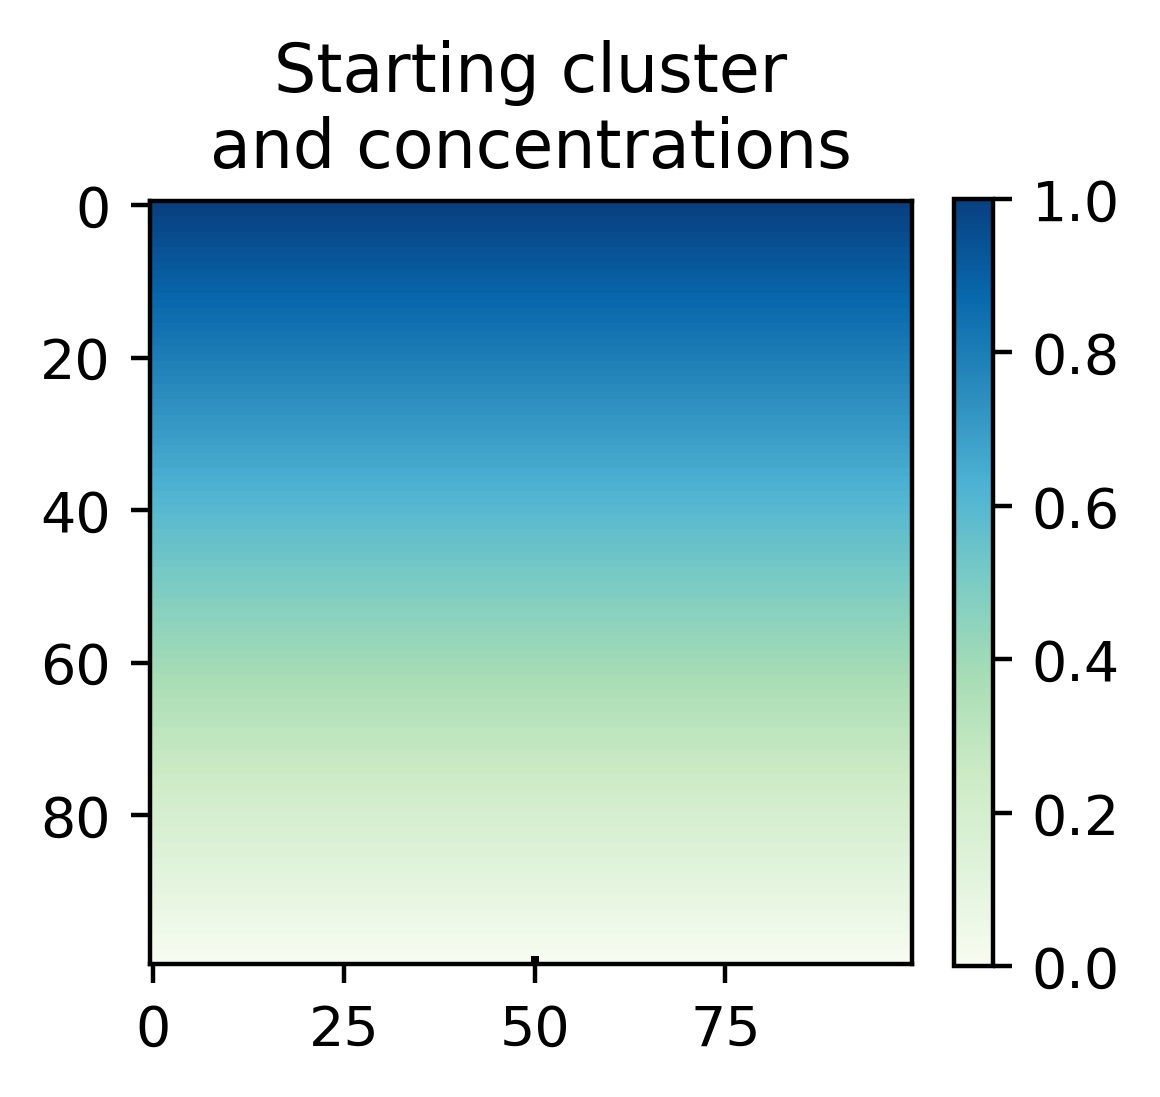

In [6]:
# Plotting of starting conditions
if SHOW_STARTING_CONDITIONS:
    # Mask cluster with concentrations
    lattice = concentrations + cluster
    masked_array = np.ma.masked_where(cluster == 1, lattice)    
    cmap = matplotlib.cm.GnBu
    cmap.set_bad(color='black')
    
    # Plot the total lattice
    plt.figure(figsize=(3,3),dpi=400)
    plt.imshow(masked_array, cmap=cmap)
    plt.title('Starting cluster\nand concentrations')
    plt.colorbar(fraction=0.0455, pad=0.05)
    plt.tight_layout()
    plt.show()

In [10]:
# SOC solving until stop_thresold
def solve_SOR(concentrations,cluster,stop_thresold,N):
    MAX_ITERATIONS = 20
    h = 1/(N + 1)
    w = 2/(1 + np.sin(np.pi * h))

    concentrations[0,:] = 1
    concentrations[N-1,:] = 0 
    
    iteration = 1
    old_c = concentrations

    while(iteration < MAX_ITERATIONS):     
        new_c = update_sor_opt(old_c,cluster,N,w) 
        delta = np.max(np.abs(new_c - old_c))
        if delta < stop_thresold:
            break
        else:
            old_c = new_c
            iteration +=1
        
    return new_c


def is_neighboor_in_bounds(neighboor,N):
    x,y = neighboor
    return True if (x >= 0 and x < N and y >= 0 and y < N) else False


def get_candidates(cluster,N):
    candidates = np.zeros((N,N))
    cluster_cell_coordinates = np.argwhere(cluster != 0)

    for cell in cluster_cell_coordinates:
        x,y = cell
        neighboors = [[x+1,y],[x-1,y],[x,y+1],[x,y-1]]

        for neighboor in neighboors:
            xn,yn = neighboor
            if is_neighboor_in_bounds(neighboor,N):
                if cluster[xn,yn] != 1:
                    candidates[xn,yn] = 1

    return candidates

def get_candidate_probabilities(candidates, concentrations, N, eta):
    probability_growth = np.zeros((N, N))
    candidates_coordinates = np.argwhere(candidates != 0)

    # FIX: Check NaN values and those under eps -> set them to 0
    values = np.power(concentrations[candidates_coordinates[:, 0], candidates_coordinates[:, 1]], eta)
    values[np.isnan(values)] = 0     
    values[np.abs(values) < np.finfo(np.float).eps] = 0
    candidate_c_sum = np.sum(values)

    for cell in candidates_coordinates:
        x, y = cell
        
        value = np.power(concentrations[x, y], eta)

        # FIX: Return special value if sum of candidate concentration is 0 -> set it to uniform
        if candidate_c_sum != 0:
            probability_growth[x, y] = value / candidate_c_sum
        else:
            probability_growth[x, y] = 1 / candidates_coordinates.shape[0]

    # FIX: Remove NaN values that could have still being produced and turn them to 0
    probability_growth[np.isnan(probability_growth)] = 0     

    return probability_growth


def coordinates_chosen_one(probability_growth,N):
    cands = np.arange(0, N**2)
    probs = probability_growth.ravel()

    # FIX: If all probs values were NaN and thus now 0 -> then return 1/N
    # Over the entire candidates
    if not np.any(probability_growth):
        probs = np.ones(probs.shape) / probs.shape

    # FIX: Sometimes probs add to a little over 1, so we normalize them
    # This will still respect the distribution
    if np.sum(probs) != 1:
        probs = probs/np.sum(probs)

    choice = np.random.choice(cands,p=probs)
    
    x = floor(choice/N)
    y = choice % N
    return x,y

In [11]:
def update(cluster,concentrations,stop_thresold,N,ETA):
    # 1. Solve time-indep Eq
    ## 1.1 Make concentrations at cluster be 0
    concentrations[cluster==1] = 0
    ## 1.2 Solve concentrations!
    concentrations = solve_SOR(concentrations,cluster,stop_thresold,N)
    # 2. Locate growth candidates around cluster
    candidates = get_candidates(cluster,N)
    probability_growth = get_candidate_probabilities(candidates,concentrations,N,ETA)

    # 3. A single candidate is added with probability p_g
    x,y = coordinates_chosen_one(probability_growth,N)
    # And then it is added to the cluster
    cluster[x,y] = 1
    return cluster,concentrations,probability_growth

In [12]:
# Repeat from 1 for a large number of growh_steps
N = 100
ETA = 0.8
STEPS = int((50/100)*N**2)
CONCENTRATION_SOLVING_THRESHOLD = 0.001
SAVE_CLUSTER_EVOLUTION = True
w = 2/(1 + np.sin(np.pi * (1/(N + 1)) ))

total_clusters = np.zeros((N,N,STEPS))
total_concentrations = np.zeros((N,N,STEPS))
total_probability_growth = np.zeros((N,N,STEPS))

# Main simulation loop  
cluster = np.zeros((N,N))
cluster[N-1,int(N/2)] = 1
total_clusters[:,:,0] = cluster

concentrations = np.zeros((N,N))

for i in range(N):
    concentrations[i,:] = 1 - i/(N-1)


for step in tqdm(range(STEPS-1)):    
    cluster,concentrations,probability_growth = update(cluster,concentrations,CONCENTRATION_SOLVING_THRESHOLD,N,ETA)
    if SAVE_CLUSTER_EVOLUTION:
        total_clusters[:,:,step+1] = cluster
        total_concentrations[:,:,step+1] = concentrations
        total_probability_growth[:,:,step+1] = probability_growth

  0%|          | 0/4999 [00:00<?, ?it/s]

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18552\2056050881.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  values[np.abs(values) < np.finfo(np.float).eps] = 0
100%|██████████| 4999/4999 [01:14<00:00, 66.74it/s] 


100 10


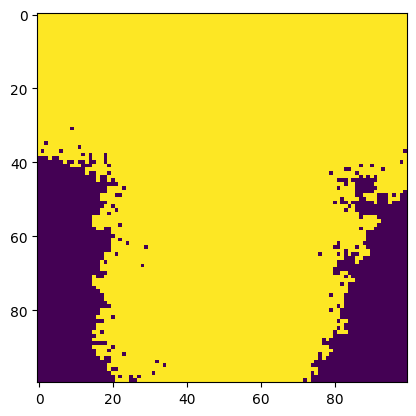

In [178]:
print(N,ETA)
plt.imshow(cluster)
#plt.imshow(concentrations)

In [ ]:
# Save results
if SAVE_CLUSTER_EVOLUTION:
    np.save(f'DLA_clusters_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_clusters)
    np.save(f'DLA_concents_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_concentrations)
    np.save(f'DLA_probabil_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_probability_growth)

In [ ]:
# Load results
total_clusters = np.load(f'DLA_clusters_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_concentrations = np.load(f'DLA_concents_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_probability_growth = np.load(f'DLA_probabil_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_17588\3960227799.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


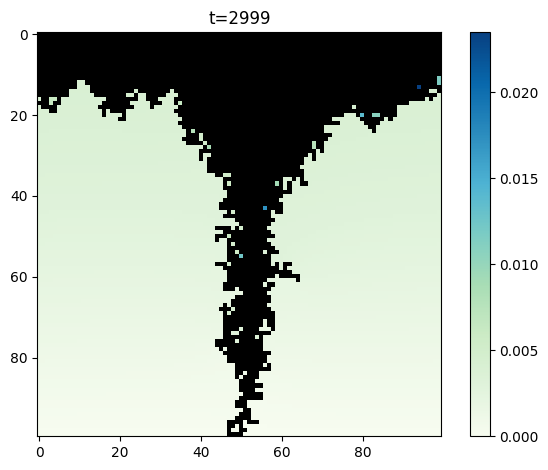

In [180]:
t=2999
lattice = total_concentrations[:,:,t] + total_clusters[:,:,t]
masked_array = np.ma.masked_where(total_clusters[:,:,t] == 1, lattice)

# Select the colormap and the color for the exception values
cmap = matplotlib.cm.GnBu
cmap.set_bad(color='black')        

# Plot the total lattice
plt.imshow(masked_array, cmap=cmap)
plt.title(f't={t}')
plt.colorbar(fraction=0.0455, pad=0.05)
plt.tight_layout()

In [53]:
# Function for animation of cluster and concentration, based on Assignment 1
def save_animation(clusters,concentrations, interval=250,fps=10,name='animation.mp4'):
        
    plt.figure(figsize=(3, 3), layout='tight')

    def update(t):
        plt.clf()
        
        lattice = concentrations[:,:,t] + clusters[:,:,t]
        masked_array = np.ma.masked_where(clusters[:,:,t] == 1, lattice)
        
        # Select the colormap and the color for the exception values
        cmap = matplotlib.cm.GnBu
        cmap.set_bad(color='black')        

        # Plot the total lattice
        plt.imshow(masked_array, cmap=cmap)
        plt.title(f't={t}')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, clusters.shape[2]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

In [54]:
# Function for animation of growth probability
def save_animation_probability(clusters,growth_probs, interval=250,fps=10,name='animation_probability.mp4',normalize=False):
        
    plt.figure(figsize=(3, 3), layout='tight')

    def update(t):
        plt.clf()
        
        lattice = growth_probs[:,:,t] + clusters[:,:,t]
        masked_array = np.ma.masked_where(clusters[:,:,t] == 1, lattice)
        
        # Select the colormap and the color for the exception values
        cmap = matplotlib.cm.GnBu.copy()
        cmap.set_bad(color='black')        

        # Plot the total lattice
        if normalize:
            masked_array = masked_array / np.max(growth_probs[:,:,t])

        plt.imshow(masked_array, cmap=cmap, vmin=0, vmax=1)
        plt.title(f't={t}')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, clusters.shape[2]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_17588\2022812745.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


KeyboardInterrupt: 

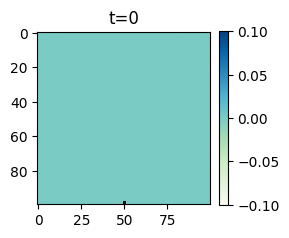

In [55]:
save_animation(total_clusters,total_concentrations, interval=250,fps=30,name=f'animation_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.mp4')

In [ ]:
# Growth probability animation
save_animation_probability(total_clusters,total_probability_growth, interval=250,fps=30,name=f'animation_prob_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.mp4',normalize=True)
      

### A.2 Run a number of growth simulations

10000 4000


  0%|          | 0/3999 [00:00<?, ?it/s]

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18552\2056050881.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  values[np.abs(values) < np.finfo(np.float).eps] = 0
100%|██████████| 3999/3999 [00:49<00:00, 80.28it/s] 
C:\Users\Pablo\AppData\Local\Temp\ipykernel_18552\2840395700.py:50: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cividis").copy()
  cmap.set_bad(color='black')
  3%|▎         | 124/3999 [00:00<00:09, 41

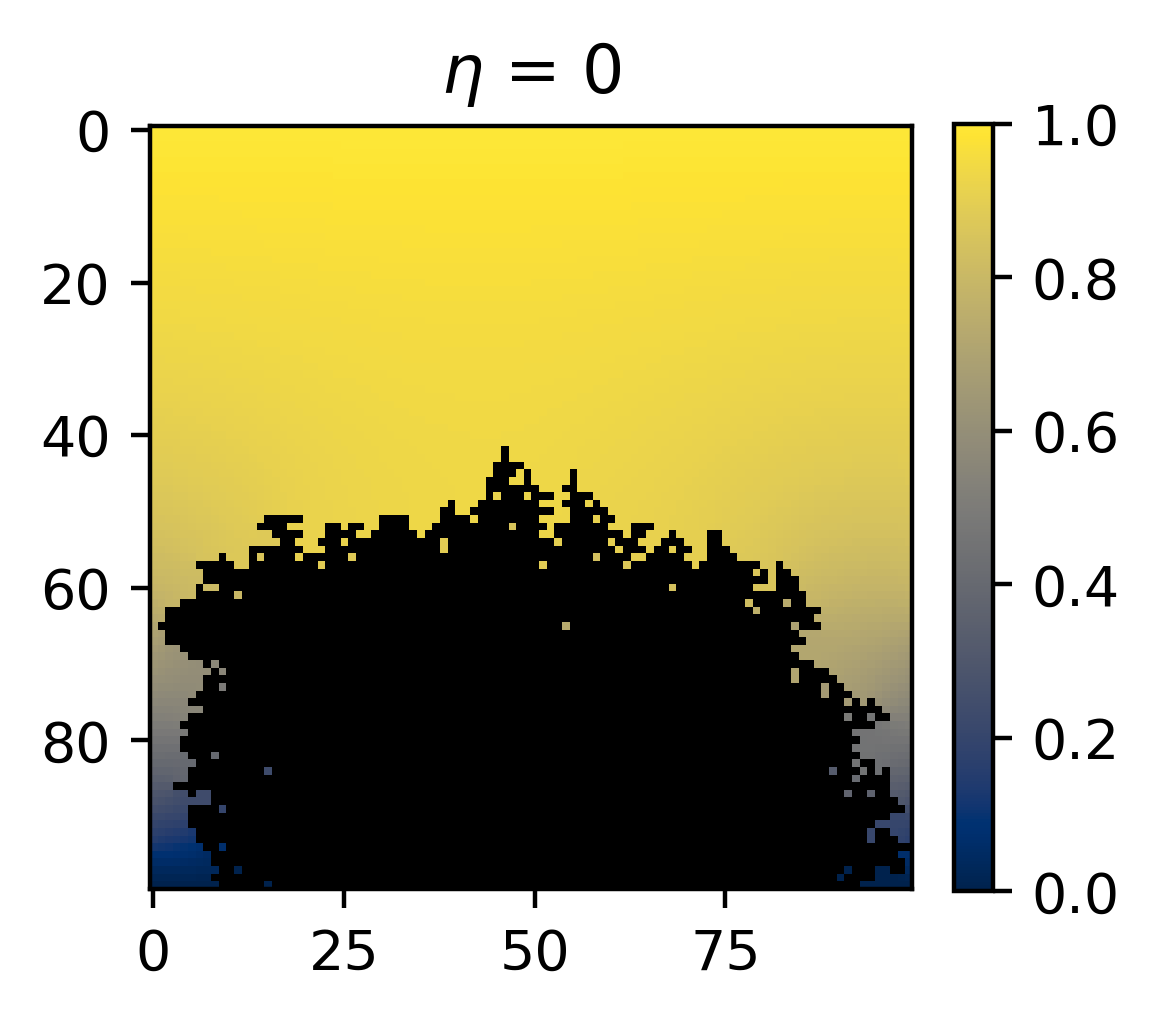

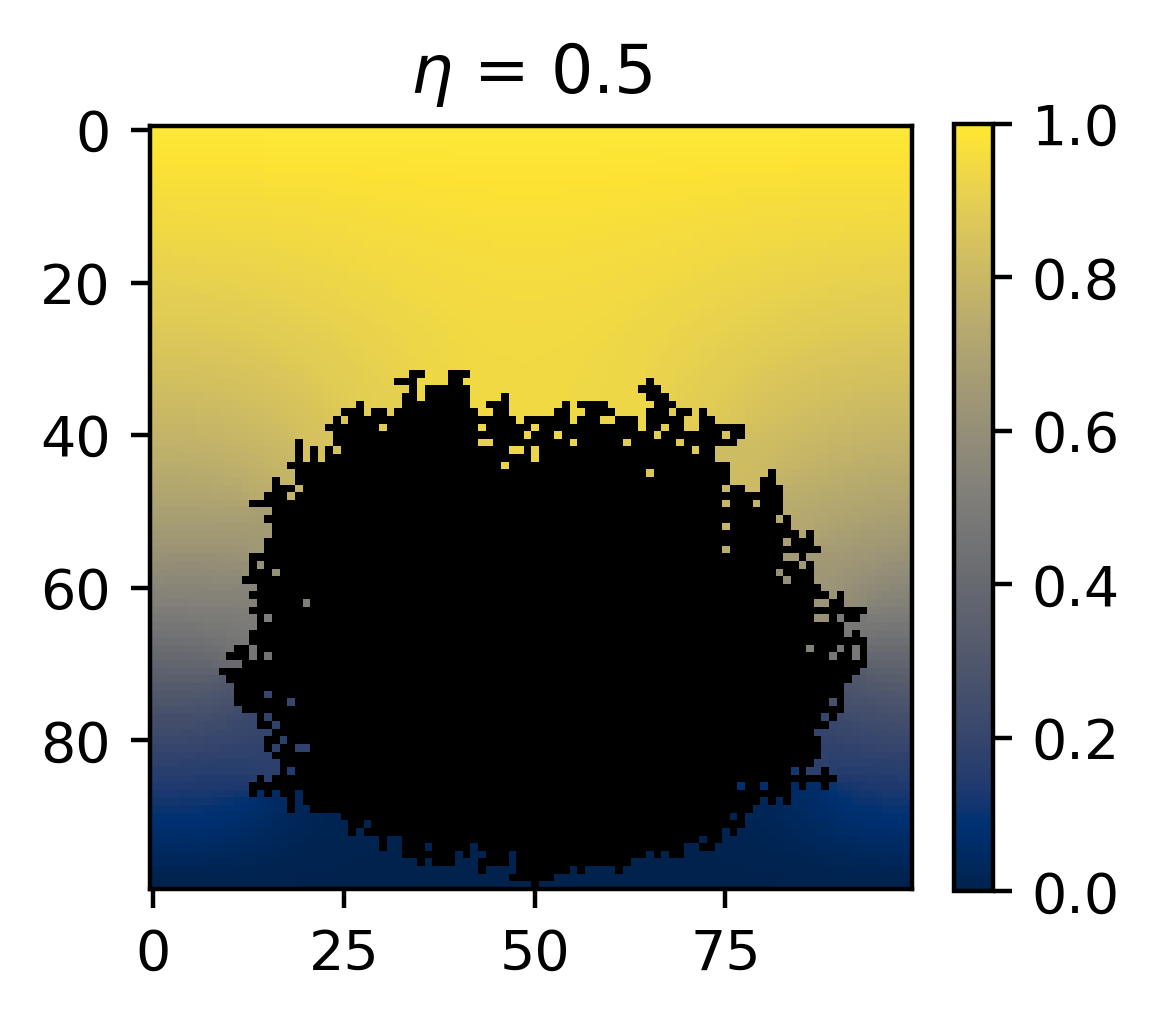

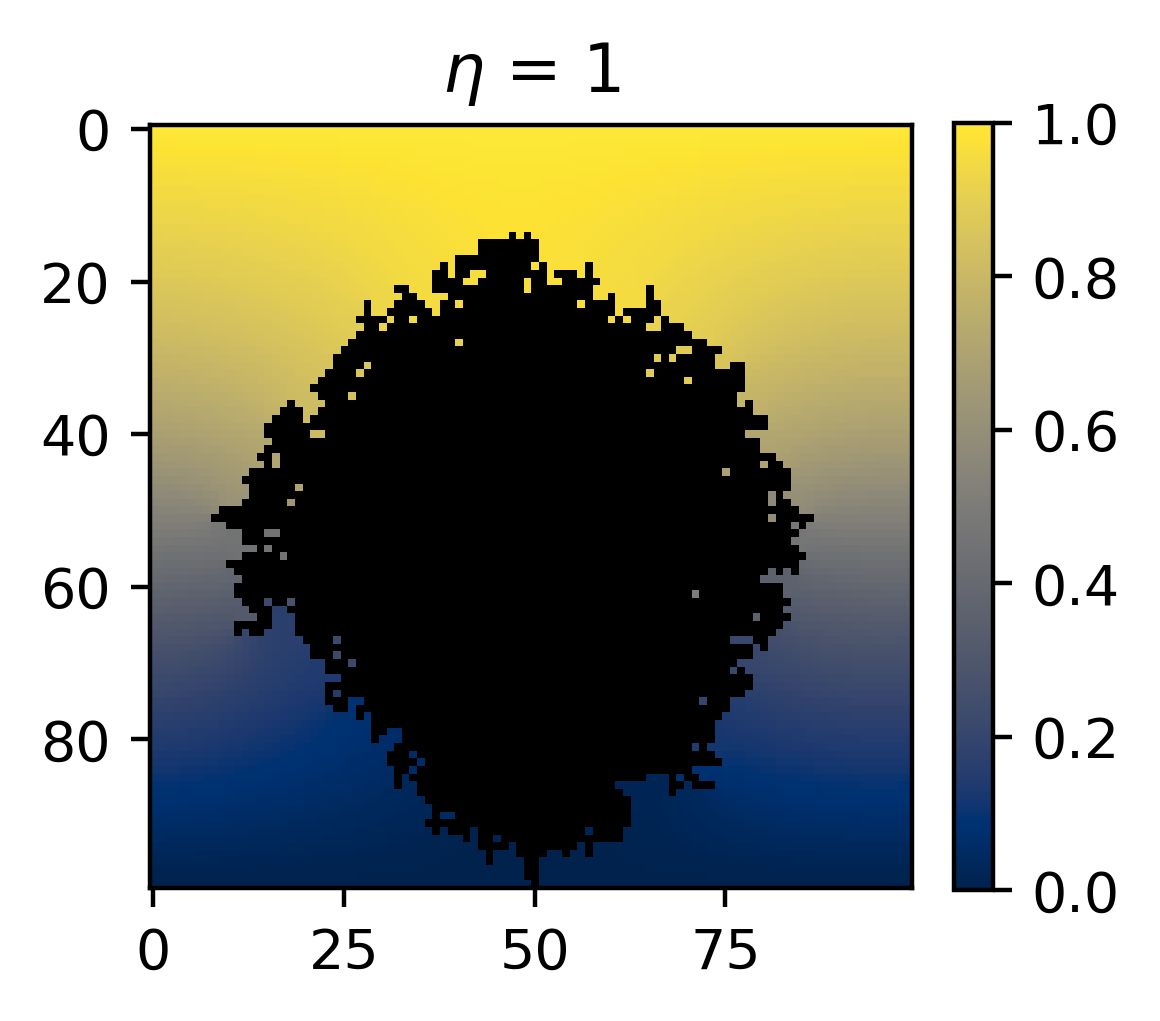

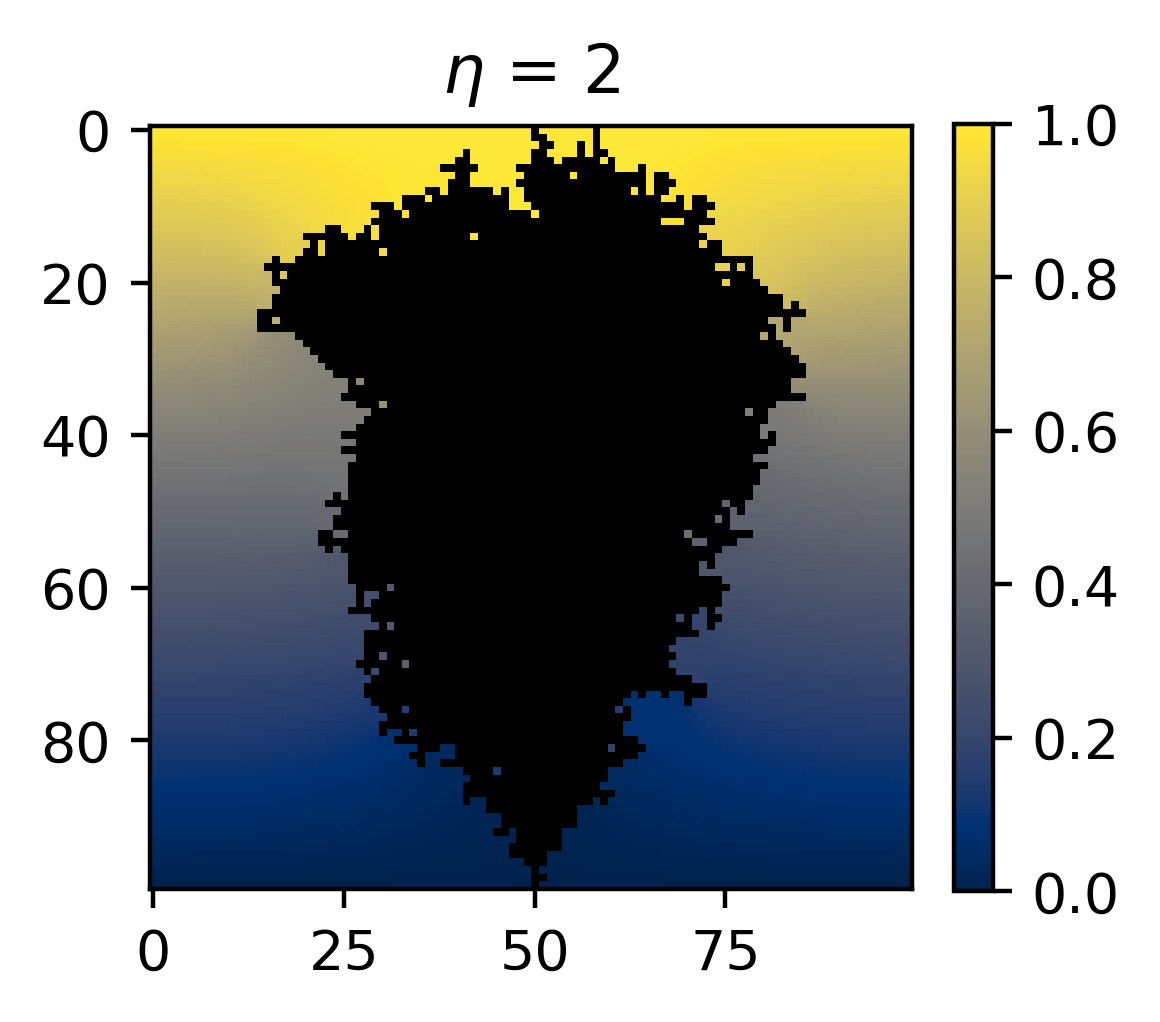

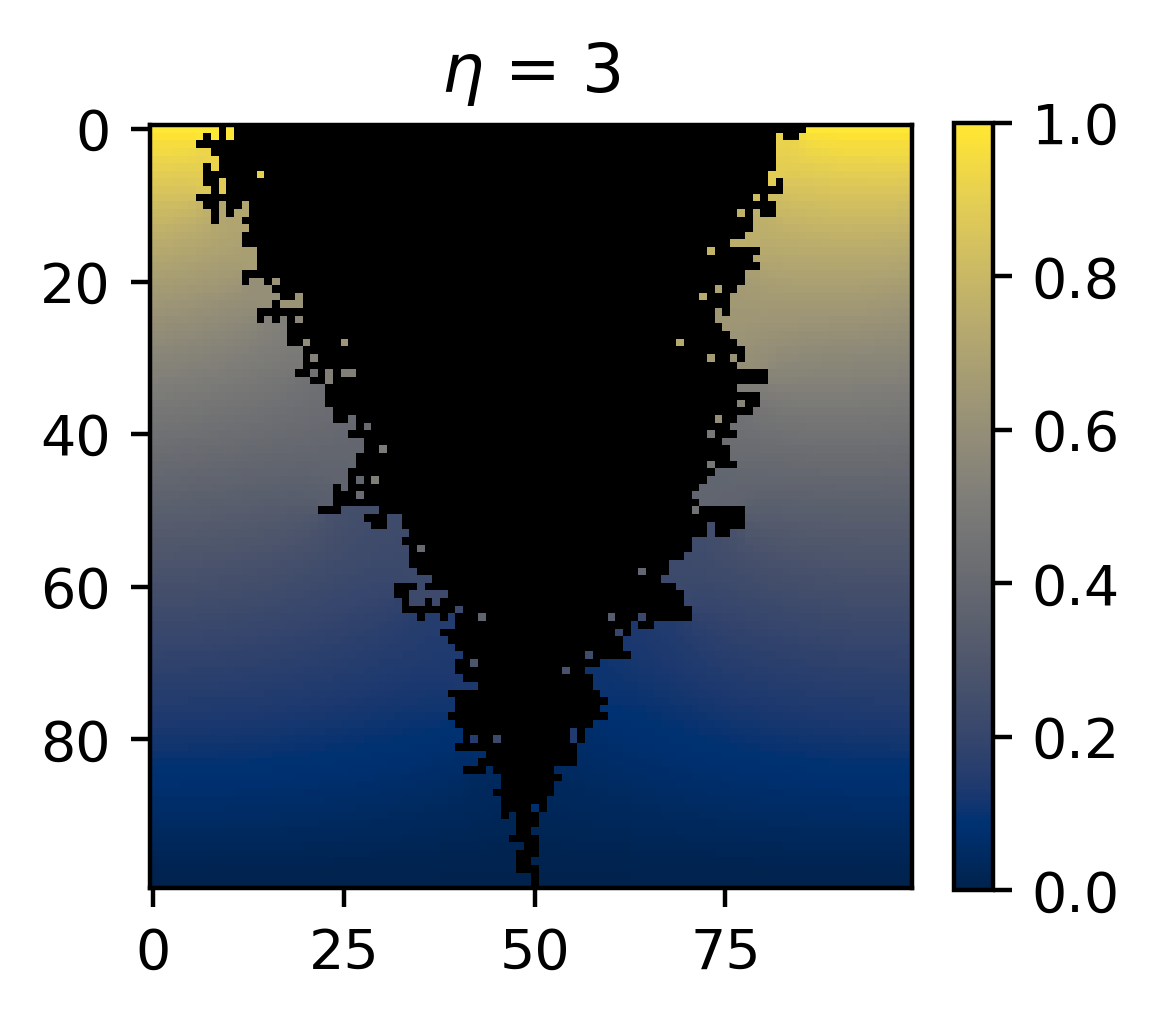

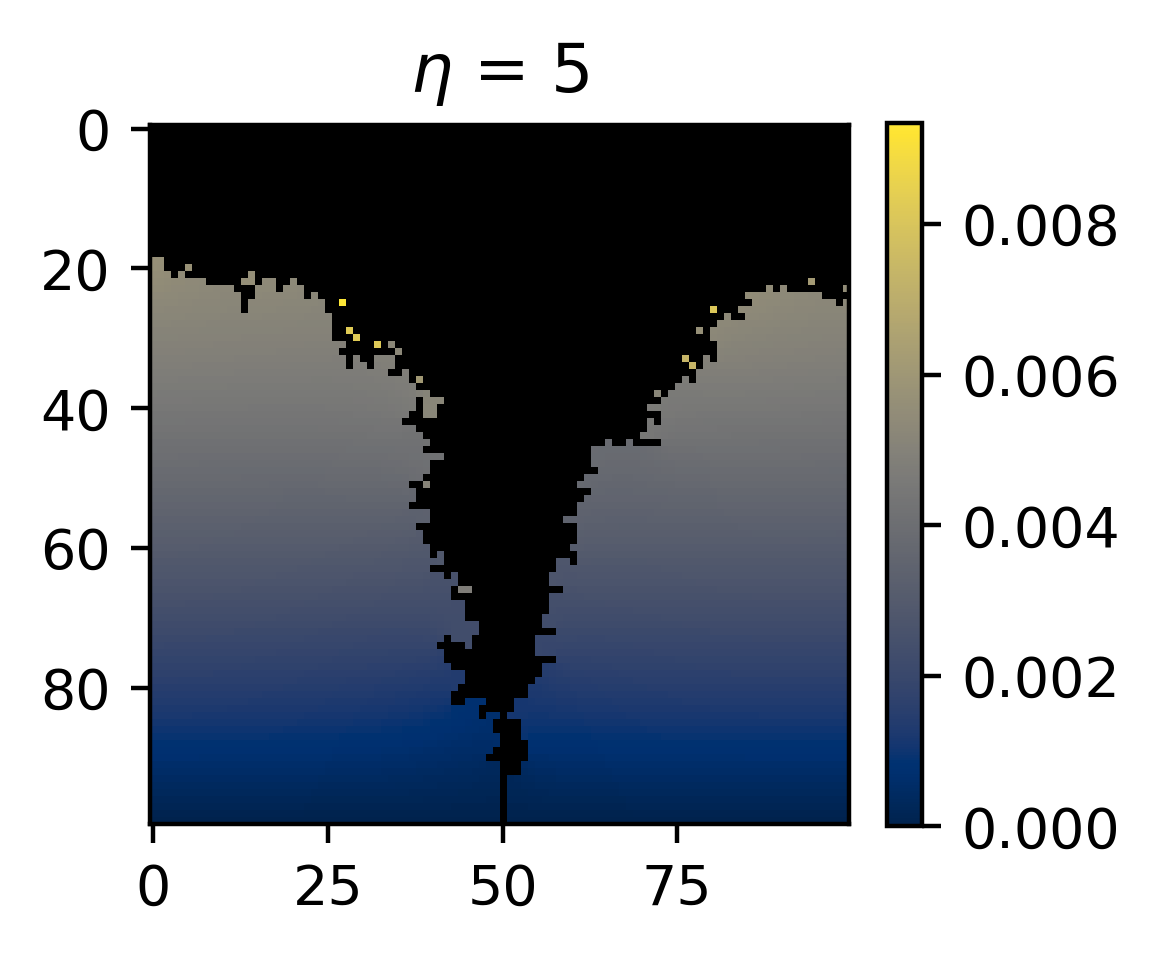

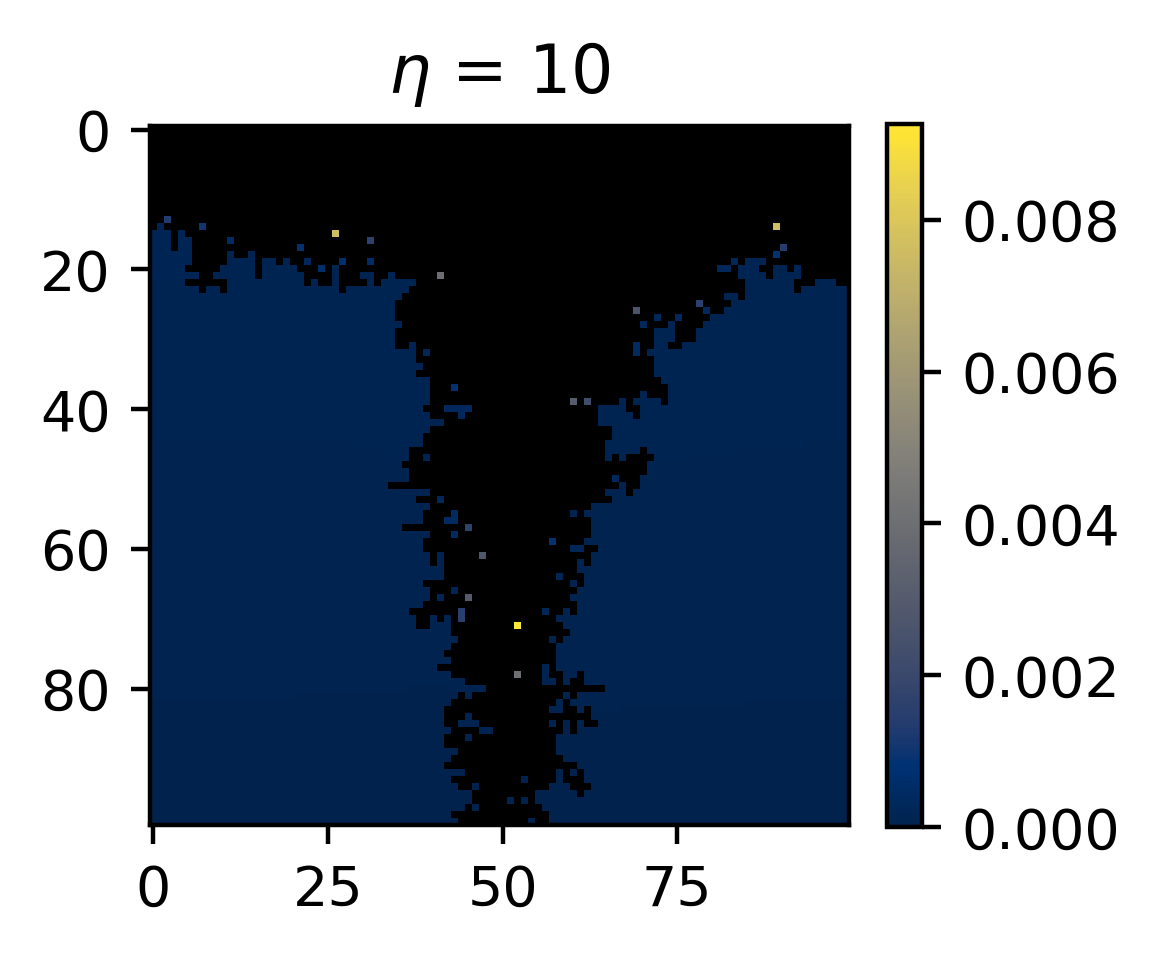

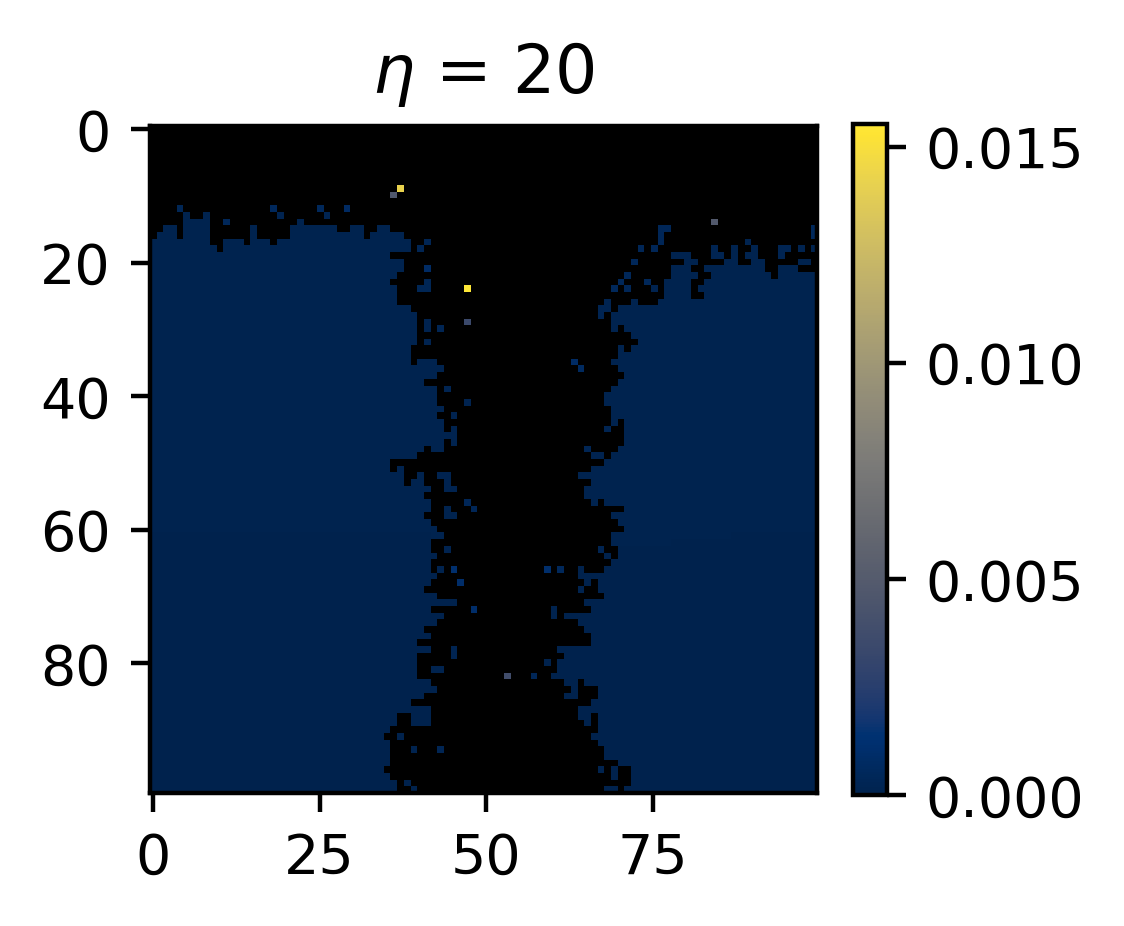

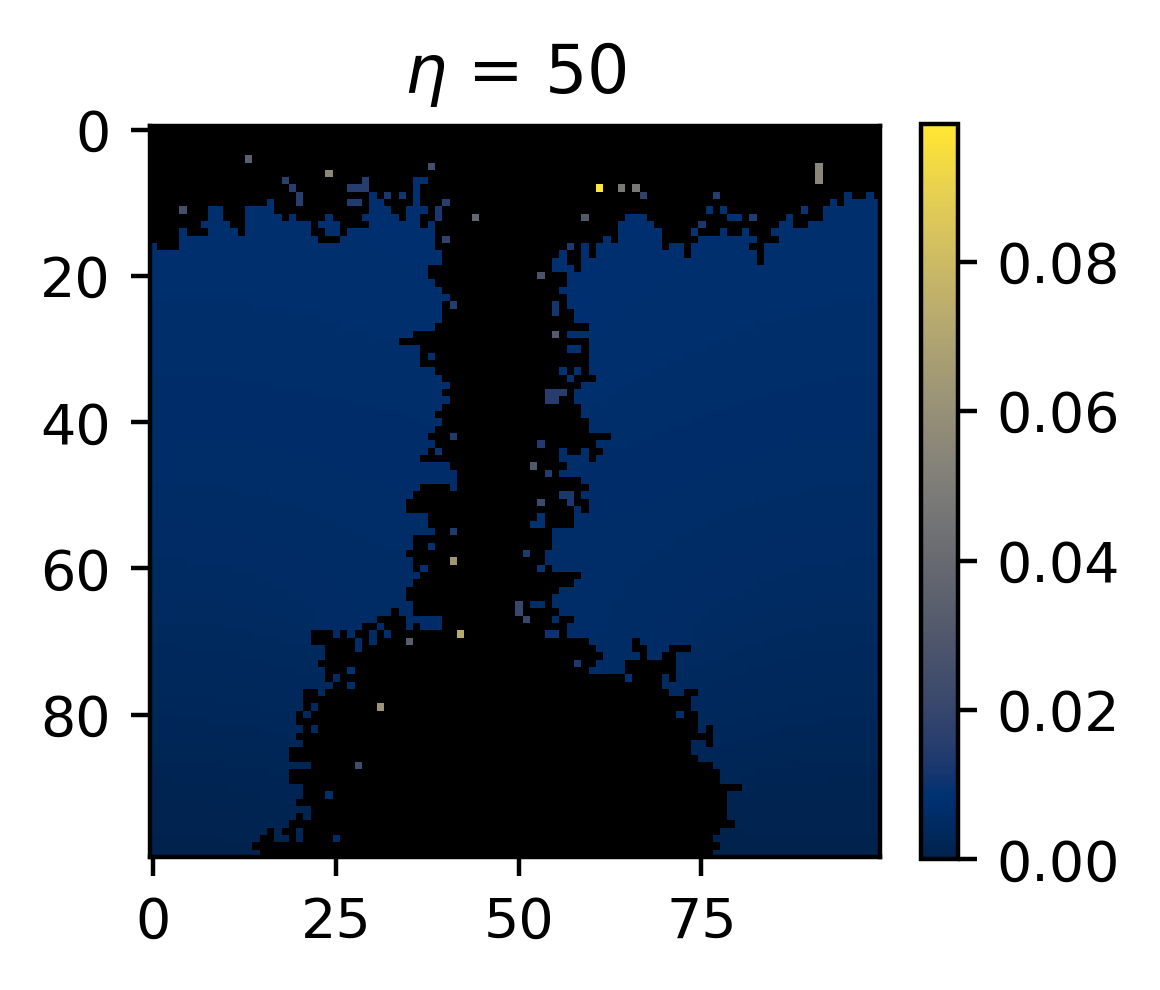

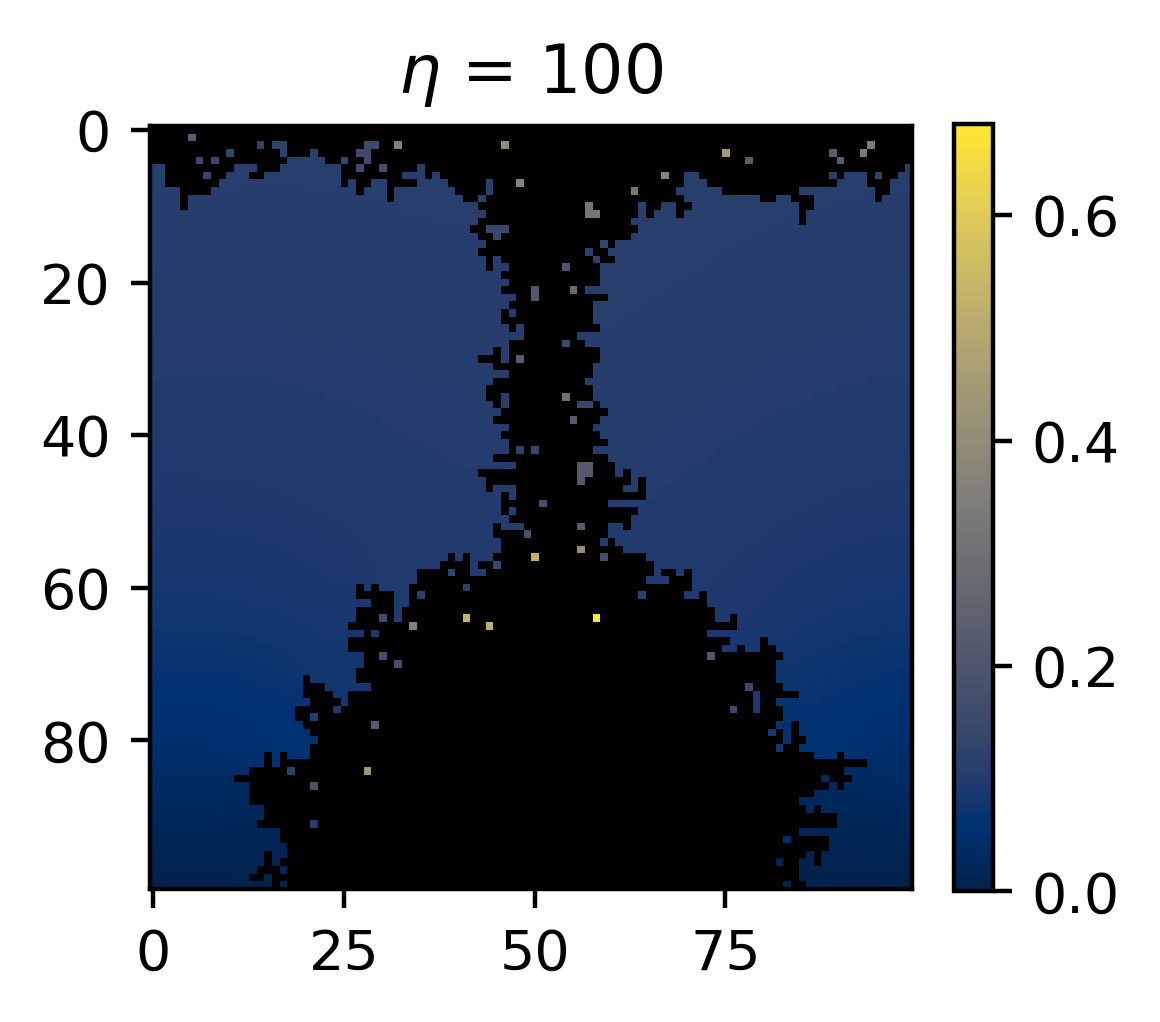

In [21]:
# TODO
ETAS = [0,0.5,1,2,3,5,10,20,50,100]
N = 100

STEPS = int((40/100)*N**2)
print(N**2,STEPS)

CONCENTRATION_SOLVING_THRESHOLD = 0.001
SAVE_CLUSTER_EVOLUTION = True
w = 2/(1 + np.sin(np.pi * (1/(N + 1)) ))


for ETA in ETAS:
    total_clusters = np.zeros((N,N,STEPS))
    total_concentrations = np.zeros((N,N,STEPS))
    total_probability_growth = np.zeros((N,N,STEPS))

    # Main simulation loop  
    cluster = np.zeros((N,N))
    cluster[N-1,int(N/2)] = 1
    total_clusters[:,:,0] = cluster

    concentrations = np.zeros((N,N))

    for i in range(N):
        concentrations[i,:] = 1 - i/(N-1)


    for step in tqdm(range(STEPS-1)):    
        cluster,concentrations,probability_growth = update(cluster,concentrations,CONCENTRATION_SOLVING_THRESHOLD,N,ETA)
        
        total_clusters[:,:,step+1] = cluster
        total_concentrations[:,:,step+1] = concentrations
        total_probability_growth[:,:,step+1] = probability_growth

    # Save
    np.save(f'part1_2/DLA_clusters_{N}_ETA_{ETA}_STEPS_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_clusters)
    np.save(f'part1_2/DLA_concents_{N}_ETA_{ETA}_STEPS_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_concentrations)
    np.save(f'part1_2/DLA_probabil_{N}_ETA_{ETA}_STEPS_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_probability_growth)

    # Plot
    t = STEPS-1 #2999

    lattice = total_concentrations[:,:,t] + total_clusters[:,:,t]
    masked_array = np.ma.masked_where(total_clusters[:,:,t] == 1, lattice)

    # Select the colormap and the color for the exception values
    #cmap = matplotlib.cm.GnBu
    cmap = matplotlib.cm.cividis
    cmap.set_bad(color='black')        

    # Plot the total lattice
    plt.figure(figsize=(3,3),dpi=400)
    plt.imshow(masked_array, cmap=cmap)
    plt.title(r"$\eta$ = "+str(ETA))
    plt.colorbar(fraction=0.0455, pad=0.05)
    plt.tight_layout()
    plt.savefig(f'part1_2/DLA_clusters_{N}_ETA_{ETA}_STEPS_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.png')
            

### A.3 Investigate the influence of the $\eta$ parameter

In [ ]:
# TODO Twist c_ij to eta
# Given single value of cluster
# Plot probabilities for different eta values!
#N = 50
#STEPS = 100
#CONCENTRATION_SOLVING_THRESHOLD = 0.001

N = 100
STEPS = 500
CONCENTRATION_SOLVING_THRESHOLD = 0.001

total_clusters = np.load(f'DLA_clusters_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_concentrations = np.load(f'DLA_concents_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_probability_growth = np.load(f'DLA_probabil_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')


In [ ]:
t = 25

cluster = total_clusters[:,:,t]
concentrations = total_concentrations[:,:,t]
probability_growth = total_probability_growth[:,:,t]

In [ ]:
ETAS = [0,1,10,100]

candidates = get_candidates(cluster,N)
pgrowth_totals = np.zeros((N,N,len(ETAS)))

for i in range(len(ETAS)):
    eta = ETAS[i]
    pgrowth_totals[:,:,i] = get_candidate_probabilities(candidates,concentrations,N,eta)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_23880\1227473321.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cividis").copy()
  cmap.set_bad(color='black')


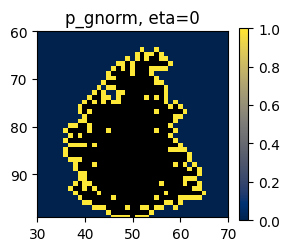

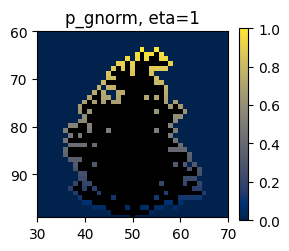

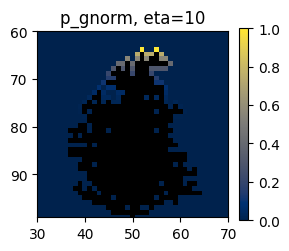

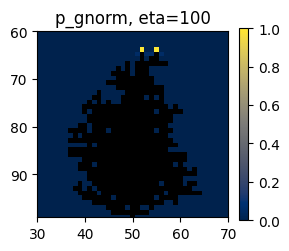

In [ ]:
# Plot normalized growth probabilities for all etas!

for i in range(len(ETAS)):

    plt.figure(figsize=(3, 3), layout='tight')
    #plt.clf()
    
    lattice = pgrowth_totals[:,:,i] + cluster
    masked_array = np.ma.masked_where(cluster == 1, lattice)
    
    # Select the colormap and the color for the exception values
    cmap = matplotlib.cm.cividis
    cmap.set_bad(color='black')        

    # Plot the total lattice
    #if normalize:
    
    # Normalize array!!!
    masked_array = masked_array / np.max(pgrowth_totals[:,:,i])
    
    #print(plt.gca().get_ylim())
    
    plt.imshow(masked_array, cmap=cmap, vmin=0, vmax=1)

    plt.xlim([30,70])
    plt.ylim([99,60])
 

#extent=[-4.50,4.50,0,3]
    plt.title(f'p_gnorm, eta={ETAS[i]}')
    plt.colorbar(fraction=0.0455, pad=0.05)
    plt.tight_layout()

## 2. Monte Carlo Simulation of DLA

### B.1 Implement the Monte Carlo version of DLA

In [6]:
# Global parameters
N = 100
STEPS = 1000
STICKING_PROBABILITY = 1

# Flags
SHOW_STARTING_CONDITIONS = True
SAVE_CLUSTER_EVOLUTION = True

In [7]:
# Innitialization
cluster = np.zeros((N,N))
cluster[0,3] = 1

In [8]:
if SAVE_CLUSTER_EVOLUTION:
    total_clusters_RW = np.zeros((N,N,STEPS))
    total_clusters_RW[:,:,0] = cluster

### Actual code

In [9]:
def rw_animation(rw_locations, interval=250,fps=10,name='rw_animation.mp4'):

    plt.figure(figsize=(3, 3), layout='tight')
    
    def update(t):
        plt.clf()
        matrix = np.zeros((N,N))

        # Add 1 to the location
        x,y = rw_locations[t,:]
        matrix[int(x),int(y)] = 1

        plt.imshow(matrix)
        plt.title(f't={t} (RW)')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, rw_locations.shape[0]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

In [10]:

def get_RW(cluster,N):
    # Get candidates in top row to start the RW    
    available_spots = np.argwhere(cluster[0,:] == 0)
    
    # Continue only if there is still space to add RW at the top
    #if available_spots == []:
    #    print('First row filled, cant add RW!')
    #    return 0,0,True

    # Pick one of the available spots at the top for the RW
    chosen = np.random.randint(0, len(available_spots)+1)

    # TODO: Check if the -1 and previous +1 add up correctly
    rw_x = available_spots[chosen-1]
    rw_y = 0

    return rw_x,rw_y

#@njit
def move_RW(x,y,N):
    # Gives the coordinates of the new RW position and
    # True or false in the 3rd argument if there was horizontal connection
    # It also does horizontal connection if neccesary
    # But it does not check if the new position if out of bounds

    # Axis of the movement: 0 for x, 1 for y
    movement_axis = np.random.choice([0,1])
    offset = np.random.choice([-1,1])

    if movement_axis==0:
        # Move in x axis
        return x+offset,y,False
    else:
        # Movement in y axis 
        # Check if we connecct with other side
        if y==0 and offset == -1:
            return x,N-1,True
        elif y==(N-1) and offset == 1:
            return x,0,True
        else:
            return x,y+offset,False


In [16]:
@njit
def update_RW(cluster,N,sticking_probability):
    if np.all(cluster[0,:]):
    #if np.all(cluster[0,:] == 1):
        print("First row full, can't add more RW, aborting!")
        return cluster,True

    # Create RWs until they stick to cluster
    RW_added = False

    while(not RW_added):
        
        #########################################
        # Get a new RW
        #x0,y0 = get_RW(cluster,N)
        
        #OLD LINE
        # available_spots = np.argwhere(cluster[0,:] == 0)

        # TODO: Optimization
        # Starting at the bottom, 
        # Find the last row that does not have cluster
        # If that row < last one
        # Then innitialize from row 
        #############################################################
        """
        ROW = N-1

        for row in cluster:
            if not np.any(row):
                break
            else:
                ROW -1

        available_spots = np.argwhere(cluster[ROW,:] == 0)

        #available_spots = np.argwhere(cluster[0,:] == 0)
        # Pick one of the available spots at the top for the RW
        chosen = np.random.randint(0, len(available_spots)+1)
        # TODO: Check if the -1 and previous +1 add up correctly
        rw_x = available_spots[chosen-1]
        rw_y = ROW

        x0,y0 = rw_x,rw_y
        """
        ############################################################

        available_spots = np.argwhere(cluster[0,:] == 0)

        #available_spots = np.argwhere(cluster[0,:] == 0)
        # Pick one of the available spots at the top for the RW
        chosen = np.random.randint(0, len(available_spots)+1)
        # TODO: Check if the -1 and previous +1 add up correctly
        rw_x = available_spots[chosen-1]
        rw_y = 0

        x0,y0 = rw_x,rw_y

        #############################################

        # Move the RW until something happens...
        # Either the RW goes outside the map or gets added
        while(not RW_added):
            #################################################
            ## Movement
            #x,y,just_moved_to_other_side = move_RW(x0,y0,N)
            movement_axis = np.random.randint(2)#np.random.random_integers(0,1) #np.random.choice([0,1],replace=False) # np.random.randint(2)
            offset = (np.random.randint(2)+np.random.randint(2))-1 #-1 or 1 # np.random.random_integers(-1,1) #np.random.choice([-1,1],replace=False) 

            
            if movement_axis==0:
                # Move in x axis
                x,y,just_moved_to_other_side = x0+offset,y0,False
            else:
                # Movement in y axis 
                # Check if we connecct with other side
                if y0==0 and offset == -1:
                    x,y,just_moved_to_other_side = x0,int(N-1),True
                elif y0==(N-1) and offset == 1:
                    x,y,just_moved_to_other_side = x0,0,True
                else:
                    x,y,just_moved_to_other_side = x0,y0+offset,False

            #print(x0,y0,x,y)
            
            #################################################
            # RW_out = bool(x<0 or x==N)
            RW_out = bool(x<0 or x==N)

            if RW_out:
                #print('RW OUT! -> New RW')
                break
            elif cluster[x,y] == 1: #and not just_moved_to_other_side:
                # New location is cluster!
                # Previous location was neighboor: add to cluster
                accept = np.random.binomial(1, sticking_probability)
                if accept:
                    cluster[x0,y0] = 1

                    RW_added = True
                    return cluster,True
                #else:
                    # Reject movement to leader!
                    # x,y = x,y
                #    pass
            else:
                # Continue moving!
                x0,y0 = x,y

    #return cluster,full


In [17]:
# Main simulation loop
N = 100
STEPS = int((0.4)*(N**2)) # 60% of the entire space
STICKING_PROBABILITY = 0.8

In [18]:
# First cluster
cluster = np.zeros((N,N))
cluster[N-1,int(N/2)] = 1

total_clusters_RW = np.zeros((N,N,STEPS))
total_clusters_RW[:,:,0] = cluster

In [19]:
# Simulation
for step in tqdm(range(STEPS-1)):    
    cluster,full = update_RW(cluster,N,STICKING_PROBABILITY)
    total_clusters_RW[:,:,step+1] = cluster

100%|██████████| 3999/3999 [00:14<00:00, 285.57it/s] 


Text(0.5, 1.0, 'N=100,p_s=0.8,STEPS=4000')

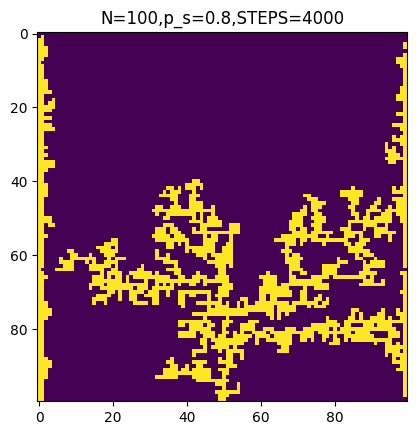

In [20]:
plt.imshow(cluster)
plt.title(f"N={N},p_s={STICKING_PROBABILITY},STEPS={STEPS}")

100%|██████████| 2999/2999 [00:32<00:00, 93.00it/s]  


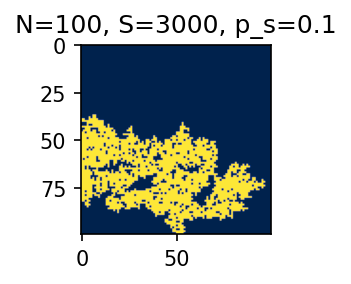

100%|██████████| 2999/2999 [00:24<00:00, 121.05it/s] 


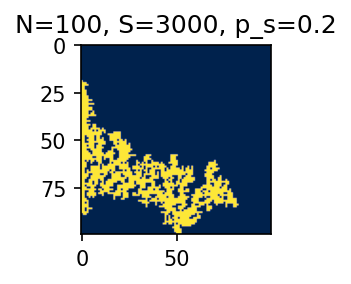

100%|██████████| 2999/2999 [00:18<00:00, 159.26it/s] 


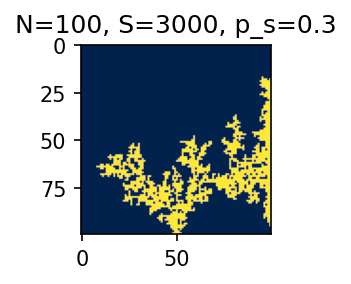

100%|██████████| 2999/2999 [00:16<00:00, 182.56it/s] 


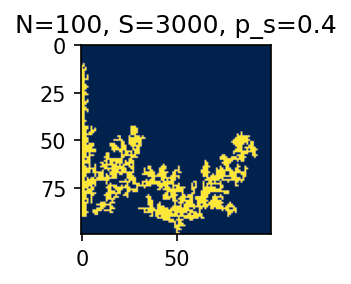

100%|██████████| 2999/2999 [00:20<00:00, 148.65it/s] 


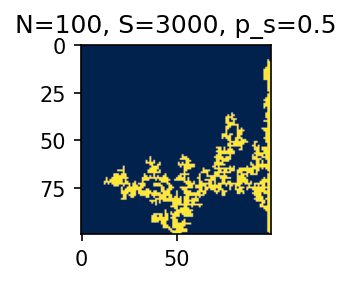

100%|██████████| 2999/2999 [00:16<00:00, 183.87it/s] 


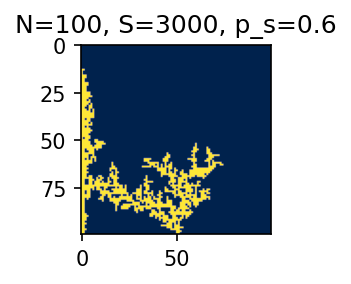

100%|██████████| 2999/2999 [00:13<00:00, 216.31it/s] 


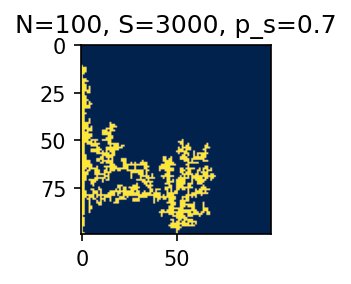

100%|██████████| 2999/2999 [00:16<00:00, 179.34it/s] 


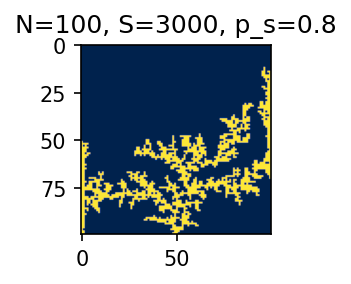

100%|██████████| 2999/2999 [00:13<00:00, 221.73it/s] 


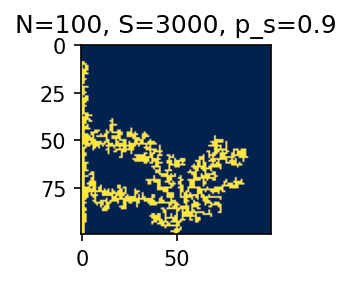

100%|██████████| 2999/2999 [00:11<00:00, 261.96it/s] 


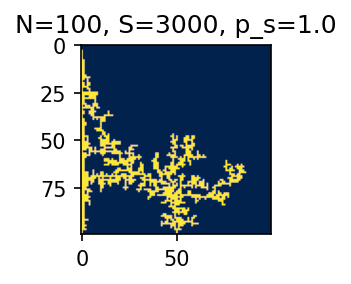

In [ ]:
# Many sims, one for each psticking
N = 100
STEPS = int((0.40)*(N**2)) # 30% of the entire space

# p values
for p in np.linspace(0.1,1,10):

    STICKING_PROBABILITY = p
    cluster = np.zeros((N,N))
    cluster[N-1,int(N/2)] = 1

    total_clusters_RW = np.zeros((N,N,STEPS))
    #total_clusters_RW[:,:,0] = cluster

    for step in tqdm(range(STEPS-1)):    
        cluster,full = update_RW(cluster,N,STICKING_PROBABILITY)
        #total_clusters_RW[:,:,step+1] = cluster

    plt.figure(figsize=(2,2),dpi=150)
    plt.imshow(cluster,cmap="cividis")
    plt.title(f"N={N}, S={STEPS}, p_s={round(STICKING_PROBABILITY,2)}")
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'p=0.1')

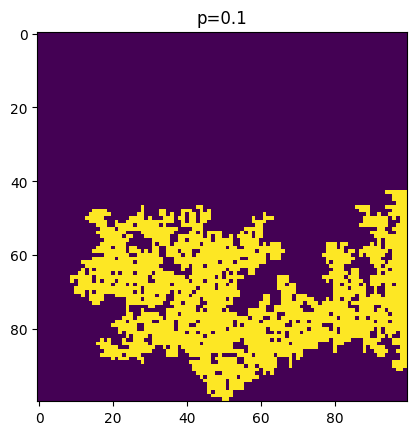

In [ ]:
# Visualize last cluster
plt.imshow(cluster)


In [ ]:
# Slooow for bit sims
total_concentrations = np.zeros((N,N,STEPS))
save_animation_probability(total_concentrations,total_clusters_RW, interval=250,fps=30,name=f'RW_evolution_N{N}_s{STEPS}_p{STICKING_PROBABILITY}.mp4',normalize=True)
     
#rw_animation(total_clusters_RW, interval=250,fps=30,name=f'RW_animation_{N}_{STEPS}.mp4')

TypingError: Failed in nopython mode pipeline (step: convert make_function into JIT functions)
[1mCannot capture the non-constant value associated with variable 'clusters' in a function that may escape.
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_17704\582128406.py", line 7:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

### B.2 Compare the resulting cluster to those obtained with the diffusion equation

- We will use fractal dimension of the clusters created with both methods.

- 2

- Log-log plot


In [ ]:
# https://porespy.org/examples/metrics/tutorials/computing_fractal_dim.html
# https://github.com/ksenia007/dlaCluster
# https://phas.ubc.ca/~berciu/TEACHING/PHYS349/DLA.pdf

# Fractal dimension is slope of plot with
# N_e: number of cluster elements Within certain 
# R: radius around starting cluster point
# We compute N_e for many R values
# And compute the dimension like this: 
D = log(N_e)/log(R)


In [ ]:
# TODO

### C.1 Run the simulation for different values of $p_s$

In [ ]:
# TODO

### C.2 Plot the results

In [ ]:
# TODO

### C.3 How does cluster shape depend on $p_s$?

In [ ]:
# TODO

## 3. The Gray-Scott model

### D.1 Implement the Gray-Scott model in 2D

In [21]:
# Params
delta_t = 1
delta_x = 1,
Du = 0.16
Dv = 0.08 
f = 0.035 
k = 0.060 
I_u = 0.5 #take everywhere in the system, and 

I_v = 0.25 # in the center of the system

In [22]:
def initialize_and_fill_matrix(shape_U, shape_V, I_u, I_v, starting_shape_V='square', square_size_propotion=0.2, delta_x=1, add_random_noise='yes', prop_random_noise=0.5):

    # Rescale grid according to selected delta x
    rescaled_shape_U = int(shape_U[0]/delta_x), int(shape_U[1]/delta_x)
    rescaled_shape_V = int(shape_V[0]/delta_x), int(shape_V[1]/delta_x)

    # Initialize U, with random noise or without
    if add_random_noise == 'yes':
        U = (1 - prop_random_noise) * I_u + prop_random_noise * np.random.uniform(0, 1, rescaled_shape_U)
    else:
        U = np.ones(rescaled_shape_U) * I_u


    # Initialize V
    V = np.zeros(rescaled_shape_V)

    # Recalc square size
    square_size = int(square_size_propotion * shape_V[0])

    # Initialize V in square shape
    if starting_shape_V == 'square':
        start_index_row = (rescaled_shape_V[0] - square_size) //2
        start_index_col= (rescaled_shape_V[1] - square_size) //2

        # If we add random noise
        if add_random_noise == 'yes':
            V[start_index_row:start_index_row + square_size, start_index_col:start_index_col + square_size] = (1 - prop_random_noise) * I_v
        else:
            V[start_index_row:start_index_row + square_size, start_index_col:start_index_col + square_size] = I_v


    # Initialize V, add random noise 
    if add_random_noise == 'yes':
        V+= (prop_random_noise * np.random.uniform(0, 1, rescaled_shape_V))
   

   
   # if shape_v == 'random':
        #TODO implement random shape get some v concentration
    return U, V


In [23]:
@njit
def wrap(value, limit):
    """Implements periodic boundries that wrap around the matrix"""
    return ((value+limit)%limit)

In [24]:
@njit
def update_sim(U, V, Du, Dv, f, k, delta_t):
    """ Taves a matrix which chemical U and matrix with chemical V, Updates 1 step of reaction diffusion equation and returns U van V matrices corresponding with next time step"""
    U =  U.copy()
    V = V.copy()
    U_next = U.copy()
    V_next = V.copy()
    rows, cols = U.shape
    # We define a convolution matrix, e.g.;

    # 0.05, 0.2, 0.05
    # 0.2, -1, 0.2
    # 0.05, 0.2, 0.05

    # This represents chemical moving out from the middle cell and towards the neighbouring cells, where all the neigbouring cell concentration adds up to 1 and the full matrix sums to 0.
    # Notice cells on the direct north/south/east/west direction (hareafter called cross cells) receive receive more chemical than the diagonal & off diagonal cells.

    for i in range(rows):
        for j in range(cols):

            # First we update the U matrix

            # Diagonal cells
            # Top left diagonal
            # U_next[wrap(i-1, rows), wrap(j-1, cols)] += U[i, j] * Du * 0.05
            # # Top right diagonal
            # U_next[wrap(i-1, rows), wrap(j+1, cols)] += U[i, j] * Du * 0.05
            # # Bottom left diagonal
            # U_next[wrap(i+1, rows), wrap(j-1, cols)] += U[i, j] * Du * 0.05
            # # Bottom right diagonal
            # U_next[wrap(i+1, rows), wrap(j+1, cols)] += U[i, j] * Du * 0.05

            # Cross cells
            # Top Cross cell
            U_next[wrap(i-1, rows), wrap(j, cols)] += U[i, j] * Du * 0.25 * delta_t
            # Left Cross cell
            U_next[wrap(i, rows), wrap(j-1, cols)] += U[i, j] * Du * 0.25 * delta_t
            # Right Cross cell
            U_next[wrap(i, rows), wrap(j+1, cols)] += U[i, j] * Du * 0.25 * delta_t
            # Bottom right diagonal
            U_next[wrap(i+1, rows), wrap(j, cols)] += U[i, j] * Du * 0.25 * delta_t

            # Removing chemical from the middle cell
            U_next[i,j] += -1 * U[i,j] * Du * delta_t

            # Now the first term of the equation for u is taken vareoff, we take care of the second term (-uv^2):
            U_next[i,j] -= U[i,j] * V[i,j] * V[i,j] * delta_t

            # Now we take care of the last term
            U_next[i,j] += f * ( 1 - U[i,j]) * delta_t


            # Now we update the V matrix


            # Diagonal cells
            # Top left diagonal
            # V_next[wrap(i-1, rows), wrap(j-1, cols)] += V[i, j] * Dv * 0.05
            # # Top right diagonal
            # V_next[wrap(i-1, rows), wrap(j+1, cols)] += V[i, j] * Dv * 0.05
            # # Bottom left diagonal
            # V_next[wrap(i+1, rows), wrap(j-1, cols)] += V[i, j] * Dv * 0.05
            # # Bottom right diagonal
            # V_next[wrap(i+1, rows), wrap(j+1, cols)] += V[i, j] * Dv * 0.05

            # Cross cells
            # Top Cross cell
            V_next[wrap(i-1, rows), wrap(j, cols)] += V[i, j] * Dv * 0.25 * delta_t
            # Left Cross cell
            V_next[wrap(i, rows), wrap(j-1, cols)] += V[i, j] * Dv * 0.25 * delta_t
            # Right Cross cell
            V_next[wrap(i, rows), wrap(j+1, cols)] += V[i, j] * Dv * 0.25 * delta_t
            # Bottom right diagonal
            V_next[wrap(i+1, rows), wrap(j, cols)] += V[i, j] * Dv * 0.25 * delta_t


            # Removing chemical from the middle cell
            V_next[i,j] += -1 * V[i,j] * Dv * delta_t

            # Now the first term of the equation for u is taken vareoff, we take care of the second term (-uv^2):
            V_next[i,j] += U[i,j] * V[i,j] * V[i,j] * delta_t

            # Now we take care of the last term 
            V_next[i,j] -= (f + k)* V[i,j] * delta_t

    return U_next, V_next

In [25]:
I_u = 0.5
I_v = 0.2
init_U,init_V = initialize_and_fill_matrix(shape_U = (5,5), shape_V = (5,5), I_u=I_u, I_v=I_v, starting_shape_V='square', square_size_propotion=0.2)


In [26]:
# Testing
print(init_U)

[[0.48603347 0.53242057 0.28285432 0.63776381 0.47664442]
 [0.51219513 0.47038137 0.45038153 0.52982017 0.32762012]
 [0.34096407 0.68089281 0.72305773 0.43665466 0.38537234]
 [0.57199977 0.45436709 0.26269318 0.3280763  0.60798611]
 [0.57946197 0.263548   0.36098608 0.3655374  0.58594637]]


In [27]:
def simulator(steps, Du, Dv, f, k, shape_U = (5,5), shape_V = (5,5), I_u=I_u, I_v=I_v, starting_shape_V='square', square_size_propotion=0.2, delta_t=1, delta_x=1, add_random_noise='yes', prop_random_noise=0.5):
    """Simulates Reaction diffusion equation"""
    # Intial values and copying to avoid errors
    init_U, init_V = initialize_and_fill_matrix(shape_U = shape_U, shape_V = shape_V, I_u=I_u, I_v=I_v, starting_shape_V=starting_shape_V, square_size_propotion=square_size_propotion, delta_x=delta_x, add_random_noise=add_random_noise, prop_random_noise=prop_random_noise)
    U = init_U.copy()
    V = init_V.copy()

    # Matrices to store evolution over time
    U_over_time = np.zeros((steps, U.shape[0], U.shape[1]))
    V_over_time = np.zeros((steps, V.shape[0], V.shape[1]))

    # Set initial state
    U_over_time[0, :, :] = U.copy()
    V_over_time[0, :, :] = V.copy()
    
    
    for step in range(1, steps):
        # Update U and V
        U, V = update_sim(U, V, Du, Dv, f, k, delta_t)

        # Store evolution over time
        U_over_time[step, :, :] = U.copy()
        V_over_time[step, :, :] = V.copy()

    return U, V, U_over_time, V_over_time

In [28]:
@njit
def update_sim(U, V, Du, Dv, f, k, delta_t):
    """ Taves a matrix which chemical U and matrix with chemical V, Updates 1 step of reaction diffusion equation and returns U van V matrices corresponding with next time step"""
    U =  U.copy()
    V = V.copy()
    U_next = U.copy()
    V_next = V.copy()
    rows, cols = U.shape
    for i in range(rows):
        for j in range(cols):

            # First we update the U matrix

            # Cross cells
            # Top Cross cell
            U_next[wrap(i-1, rows), wrap(j, cols)] += U[i, j] * Du * 0.25 * delta_t
            # Left Cross cell
            U_next[wrap(i, rows), wrap(j-1, cols)] += U[i, j] * Du * 0.25 * delta_t
            # Right Cross cell
            U_next[wrap(i, rows), wrap(j+1, cols)] += U[i, j] * Du * 0.25 * delta_t
            # Bottom right diagonal
            U_next[wrap(i+1, rows), wrap(j, cols)] += U[i, j] * Du * 0.25 * delta_t

            # Removing chemical from the middle cell
            U_next[i,j] += -1 * U[i,j] * Du * delta_t

            # Now the first term of the equation for u is taken vareoff, we take care of the second term (-uv^2):
            U_next[i,j] -= U[i,j] * V[i,j] * V[i,j] * delta_t

            # Now we take care of the last term
            U_next[i,j] += f * ( 1 - U[i,j]) * delta_t


            # Next we update the V matrix

            # Cross cells
            # Top Cross cell
            V_next[wrap(i-1, rows), wrap(j, cols)] += V[i, j] * Dv * 0.25 * delta_t
            # Left Cross cell
            V_next[wrap(i, rows), wrap(j-1, cols)] += V[i, j] * Dv * 0.25 * delta_t
            # Right Cross cell
            V_next[wrap(i, rows), wrap(j+1, cols)] += V[i, j] * Dv * 0.25 * delta_t
            # Bottom right diagonal
            V_next[wrap(i+1, rows), wrap(j, cols)] += V[i, j] * Dv * 0.25 * delta_t


            # Removing chemical from the middle cell
            V_next[i,j] += -1 * V[i,j] * Dv * delta_t

            # Now the first term of the equation for u is taken vareoff, we take care of the second term (-uv^2):
            V_next[i,j] += U[i,j] * V[i,j] * V[i,j] * delta_t

            # Now we take care of the last term 
            V_next[i,j] -= (f + k)* V[i,j] * delta_t

    return U_next, V_next

In [29]:
# Function for animation of cluster and concentration, based on Assignment 1
def save_animation_part_3(concentrations, interval=250,fps=10,name='animation_part_3_non_diag.mp4'):
        
    plt.figure(figsize=(3, 3), layout='tight')

    def update(t):
        plt.clf()
        
        lattice = concentrations[t,:,:]
        
        # Select the colormap and the color for the exception values
        cmap = matplotlib.cm.GnBu
        cmap.set_bad(color='black')        

        # Plot the total lattice
        plt.imshow(np.round(lattice,4), cmap=cmap)
        plt.title(f't={t}')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, concentrations.shape[0]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

In [30]:
def plot_U_and_V_endstates(data, timepoint = 0):
    U, V, U_over_time, V_over_time = data
    # Obtaining last steps index, which is the same for U and V
    
    if timepoint == 'last':
        timepoint = U_over_time.shape[0] - 1

    # Plotting U
    print('Plot of U')
    plt.figure(dpi=250, figsize=(3,3))
    plt.imshow(np.round(U_over_time[timepoint],5))
    # plt.title(f'Concentration of U at t={timepoint}')
    plt.colorbar(fraction=0.0455, pad=0.05)
    plt.tight_layout()
    plt.show()

    # Plotting V
    print('Plot of V')
    plt.figure(dpi=250, figsize=(3,3))
    plt.imshow(np.round(V_over_time[timepoint],5))
    # plt.title(f'Concentration of V at={timepoint}')
    plt.colorbar(fraction=0.0455, pad=0.05)
    plt.tight_layout()
    plt.show()


### D.3 Plot the resulting concentrations of U and V for several parameter choices

Simulating with various interesting parameters combinations

In [31]:
k = 0.060
f = 0.035
steps = 20000
data_1 = simulator(20000, Du, Dv, f, k, shape_U = (100,100), shape_V = (100,100), I_u=I_u, I_v=I_v, starting_shape_V='square', square_size_propotion=0.2, add_random_noise='no', prop_random_noise=0.01)
data_1_inc_noise = simulator(20000, Du, Dv, f, k, shape_U = (100,100), shape_V = (100,100), I_u=I_u, I_v=I_v, starting_shape_V='square', square_size_propotion=0.2, add_random_noise='yes', prop_random_noise=0.1)



Plot of U


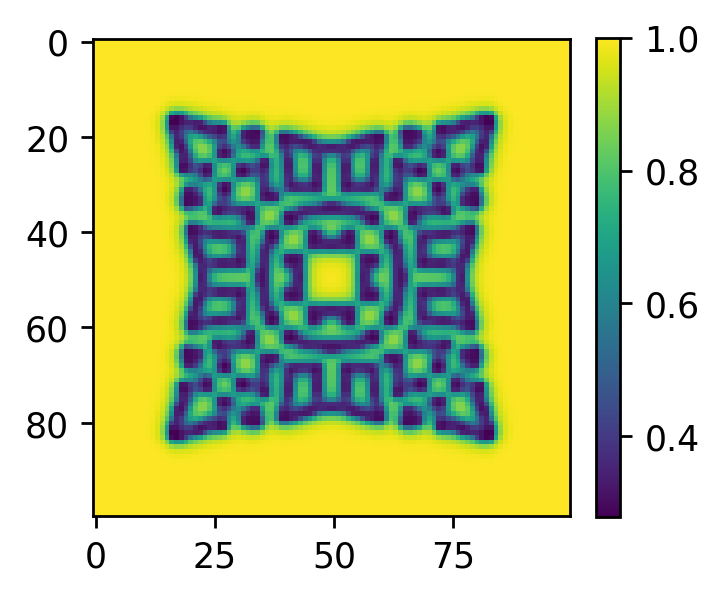

Plot of V


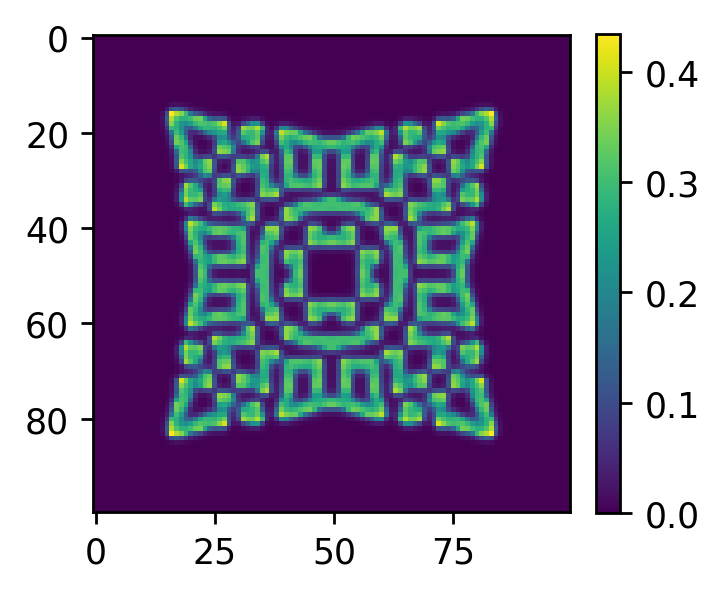

Plot of U


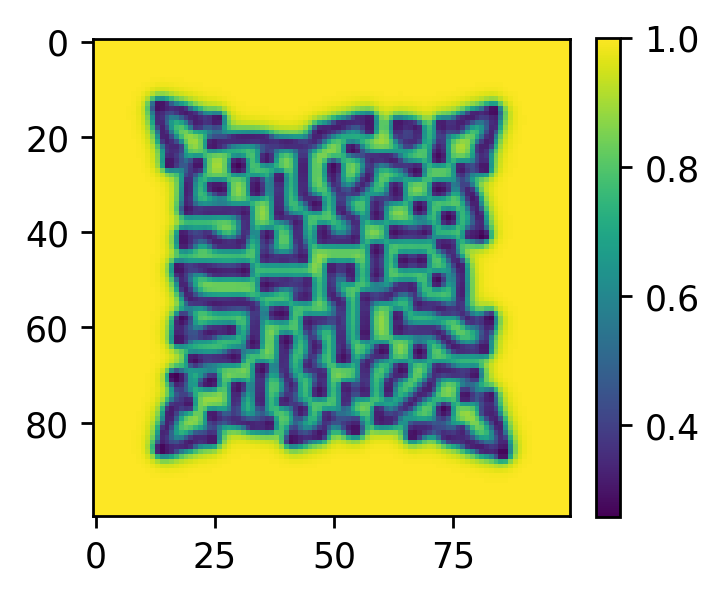

Plot of V


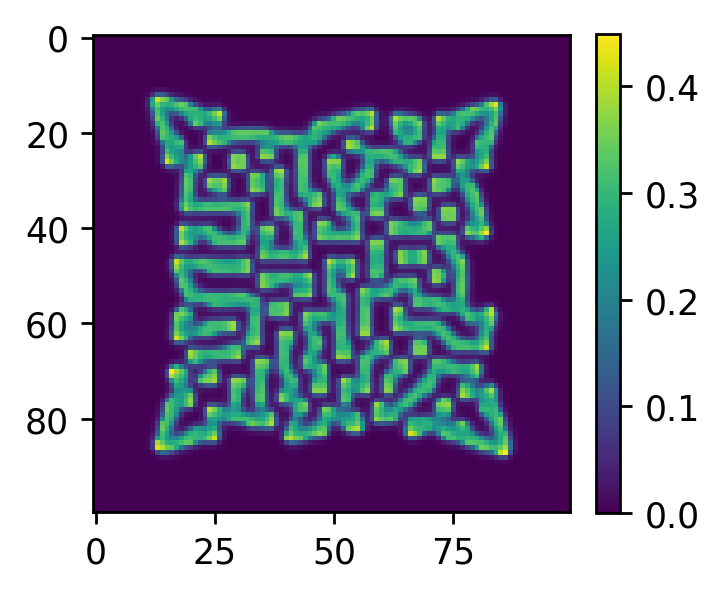

In [32]:
# First plot witout noise
plot_U_and_V_endstates(data_1, timepoint= 5000)
plot_U_and_V_endstates(data_1_inc_noise, timepoint = 5000)

Next set of params

In [33]:
k = 0.029
f = 0.057
steps = 20000
data_2 = simulator(20000, Du, Dv, f, k, shape_U = (100,100), shape_V = (100,100), I_u=I_u, I_v=I_v, starting_shape_V='square', square_size_propotion=0.2, add_random_noise='no', prop_random_noise=0.01)
data_2_inc_noise = simulator(20000, Du, Dv, f, k, shape_U = (100,100), shape_V = (100,100), I_u=I_u, I_v=I_v, starting_shape_V='square', square_size_propotion=0.2, add_random_noise='yes', prop_random_noise=0.1)



Plot of U


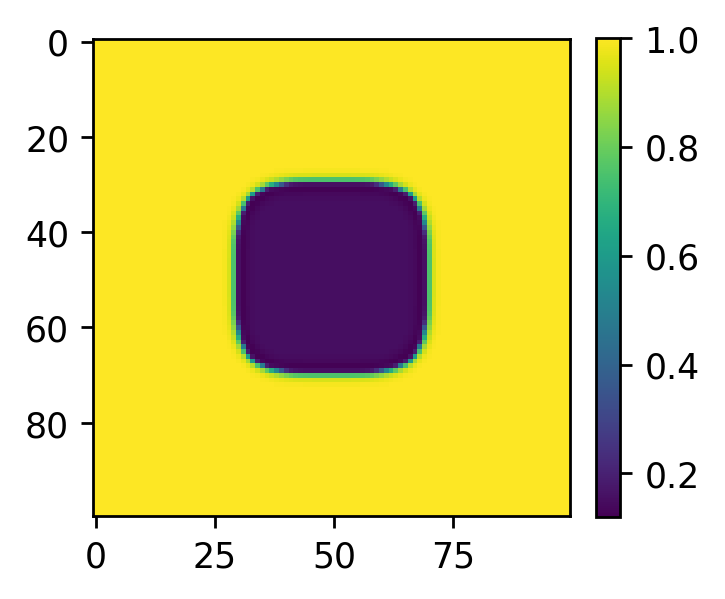

Plot of V


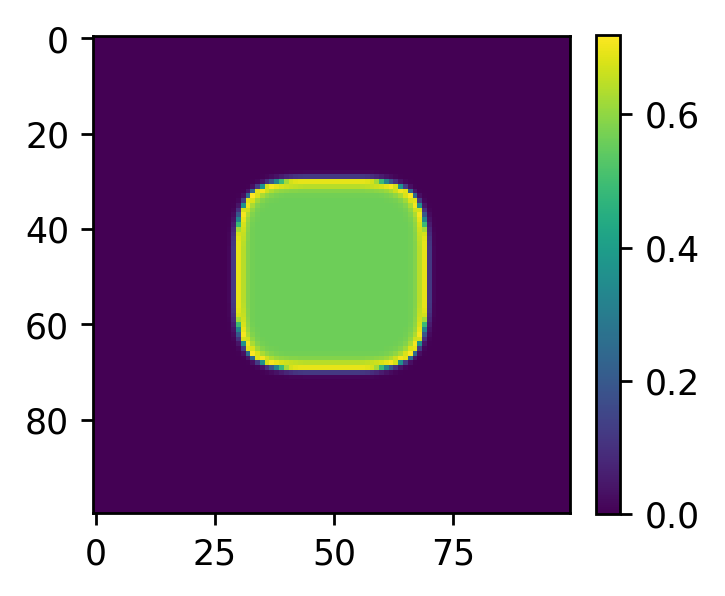

Now we print with Noise
Plot of U


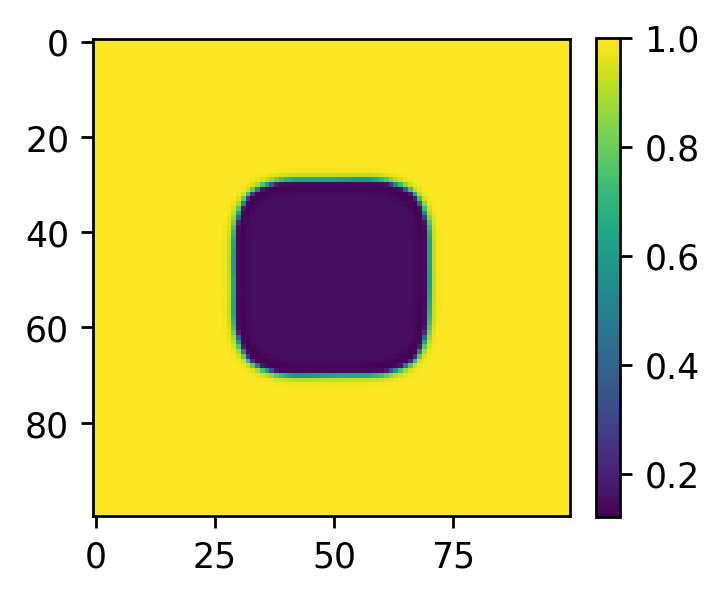

Plot of V


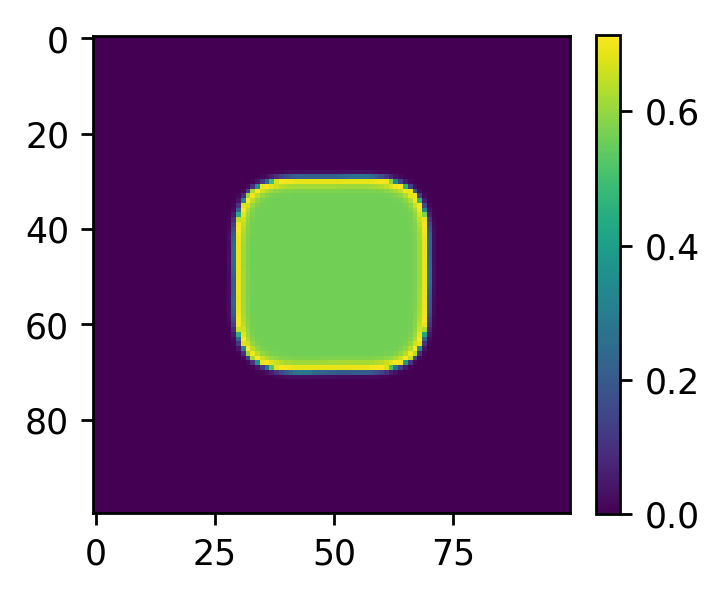

In [34]:
plot_U_and_V_endstates(data_2, 300)
print('Now we print with Noise')
plot_U_and_V_endstates(data_2_inc_noise, 300)

Next set of params

In [35]:
k = 0.06
f = 0.03
steps = 20000
data_3 = simulator(20000, Du, Dv, f, k, shape_U = (100,100), shape_V = (100,100), I_u=I_u, I_v=I_v, starting_shape_V='square', square_size_propotion=0.2, add_random_noise='no', prop_random_noise=0.01)
data_3_inc_noise = simulator(20000, Du, Dv, f, k, shape_U = (100,100), shape_V = (100,100), I_u=I_u, I_v=I_v, starting_shape_V='square', square_size_propotion=0.2, add_random_noise='yes', prop_random_noise=0.1)



Plot of U


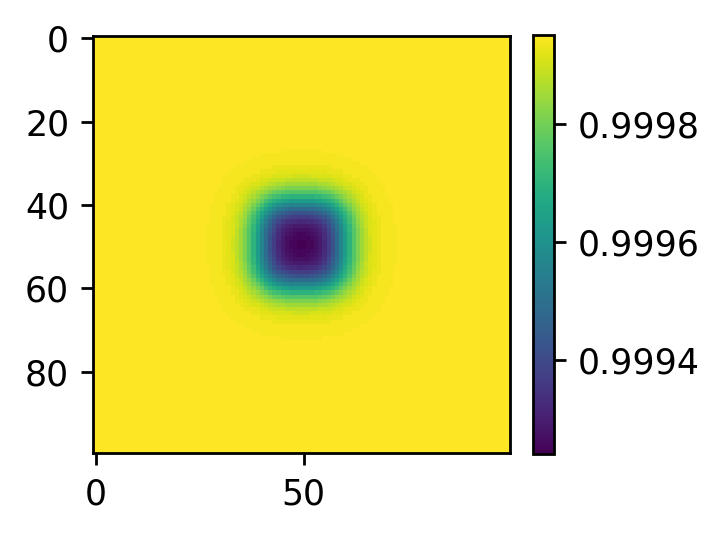

Plot of V


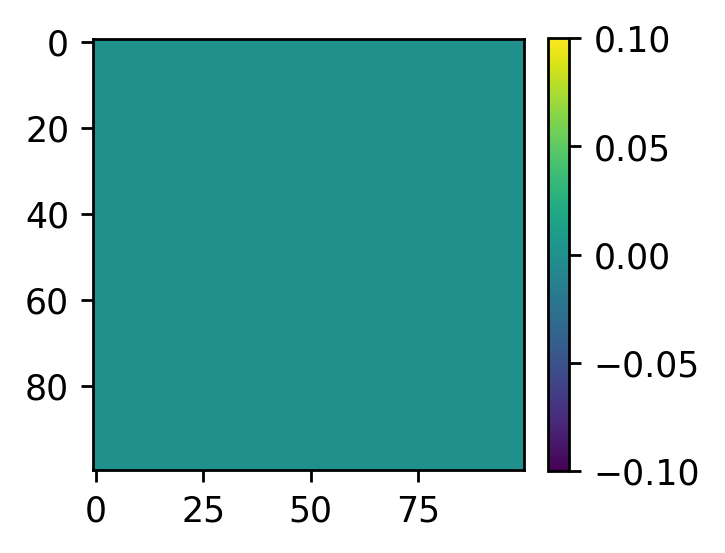

Plot of U


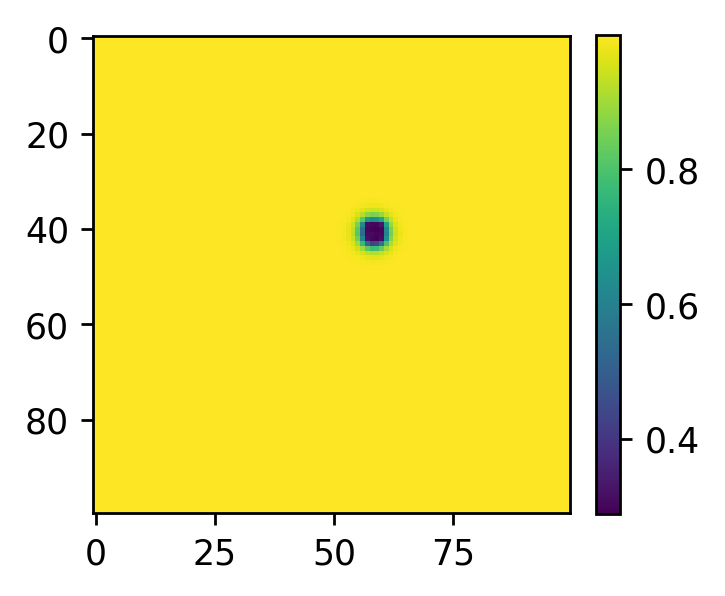

Plot of V


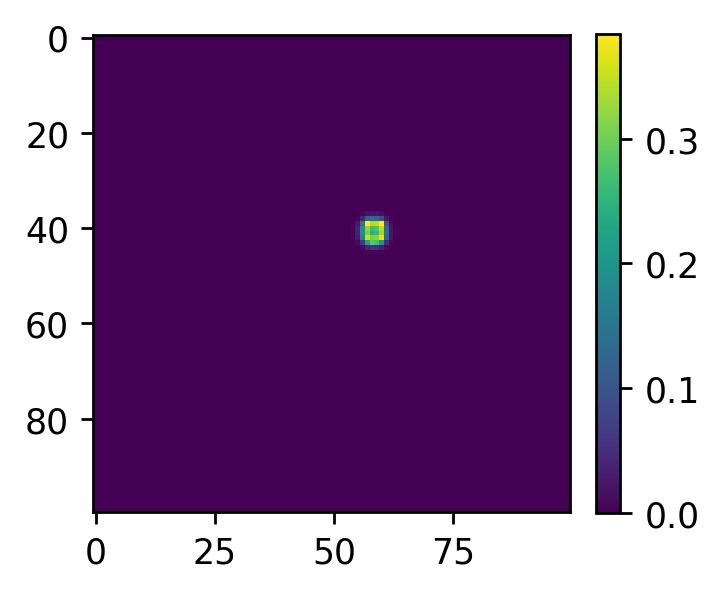

In [36]:
plot_U_and_V_endstates(data_3, 300)
plot_U_and_V_endstates(data_3_inc_noise, 300)

KeyboardInterrupt: 

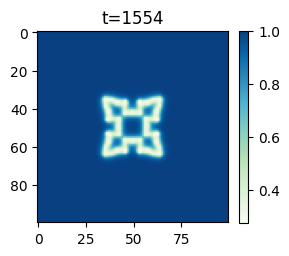

In [37]:
save_animation_part_3(data_1[2])